# Convolutional Autoencoder

Yeah, I'm apparently actually doing this.

Structure is roughly as follows.

- Convolutional layer
- Symmetric(!!!) activation layer
- Max pooling layer
- Dropout layer
- Flatten layer
- Dense layer
- Symmetric activation layer
- Unflatten layer
- Unpool layer
- Deconvolutional layer
- Symmetric activation layer

Inspiration from https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.py and https://github.com/nanopony/keras-convautoencoder/blob/master/conv_autoencoder.py.

Let's load up the dataset I put up on Zenodo.

In [52]:
import h5py, numpy

with h5py.File('../data/dataset.h5', 'r') as f:
    features = f['features'][:, -32 * 32:]

Now we'll build an autoencoder...

In [157]:
import keras, \
        keras.layers, \
        keras.layers.core as core, \
        keras.layers.convolutional as conv, \
        keras.models as models
from keras import backend as K
from keras.engine.topology import Layer

n_filters = 32
conv_size = 5
pool_size = 2
dropout = 0.25
patch_size = 32
conv_out_size = (patch_size - conv_size) // pool_size + 1
conv_2_out_size = ((patch_size - conv_size) // pool_size + 1 - conv_size) // pool_size + 1
hidden = 1500

In [54]:
class Sum(Layer):
    def __init__(self, **kwargs):
        super(Sum, self).__init__(**kwargs)

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return x.sum(axis=1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],) + input_shape[2:]

In [160]:
model = models.Sequential()

# Encoder.
model.add(conv.Convolution2D(n_filters, conv_size, conv_size,
                             border_mode='valid',
                             input_shape=(1, patch_size, patch_size)))
model.add(core.Activation('tanh'))
model.add(conv.MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(core.Dropout(dropout))
model.add(conv.Convolution2D(n_filters, conv_size, conv_size,
                             border_mode='valid'))
model.add(core.Activation('tanh'))
model.add(conv.MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(core.Dropout(dropout))
model.add(core.Flatten())

# Dense.
# model.add(core.Dense(hidden))
# model.add(core.Activation('tanh'))
# model.add(core.Dense(n_filters * conv_out_size * conv_out_size))
# model.add(core.Activation('tanh'))

# Decoder.
model.add(core.Reshape((n_filters, conv_2_out_size, conv_2_out_size)))
model.add(conv.UpSampling2D(size=(pool_size, pool_size)))
model.add(core.Activation('tanh'))
model.add(conv.ZeroPadding2D(padding=(conv_size - 1, conv_size - 1)))
model.add(conv.Convolution2D(n_filters, conv_size, conv_size,
                            border_mode='valid'))
model.add(conv.UpSampling2D(size=(pool_size, pool_size)))
model.add(core.Activation('tanh'))
model.add(conv.ZeroPadding2D(padding=(conv_size - 1, conv_size - 1)))
model.add(conv.Convolution2D(n_filters, conv_size, conv_size,
                            border_mode='valid'))
model.add(Sum())

model.compile(loss='mse', optimizer='adagrad')

In [180]:
images = features.reshape((-1, patch_size, patch_size))
model.fit(images[:10].reshape((-1, 1, patch_size, patch_size)), images[:10], nb_epoch=1000)

Epoch 1/1000
10/10 [==============================] - 0s - loss: 0.5183
Epoch 2/1000
10/10 [==============================] - 0s - loss: 0.5000
Epoch 3/1000
10/10 [==============================] - 0s - loss: 0.4398
Epoch 4/1000
10/10 [==============================] - 0s - loss: 0.5241
Epoch 5/1000
10/10 [==============================] - 0s - loss: 0.5176
Epoch 6/1000
10/10 [==============================] - 0s - loss: 0.5136
Epoch 7/1000
10/10 [==============================] - 0s - loss: 0.5556
Epoch 8/1000
10/10 [==============================] - 0s - loss: 0.4834
Epoch 9/1000
10/10 [==============================] - 0s - loss: 0.4910
Epoch 10/1000
10/10 [==============================] - 0s - loss: 0.5520
Epoch 11/1000
10/10 [==============================] - 0s - loss: 0.4347
Epoch 12/1000
10/10 [==============================] - 0s - loss: 0.4886
Epoch 13/1000
10/10 [==============================] - 0s - loss: 0.4431
Epoch 14/1000
10/10 [==============================] - 0s - 

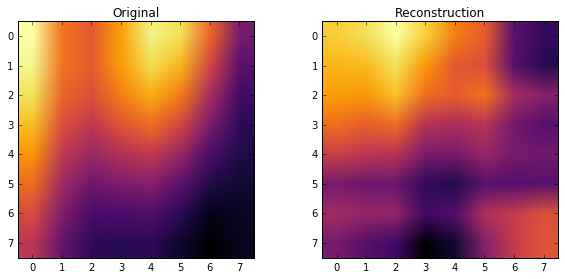

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline
z = 12
plt.figure(figsize=(10, 50))
for j, i in enumerate(numpy.random.randint(100, size=(1,))):
    plt.subplot(10, 2, 2 * j + 1)
    plt.title('Original')
    plt.imshow(images[i, z:-z, z:-z], cmap='inferno')
    plt.subplot(10, 2, 2 * j + 2)
    plt.title('Reconstruction')
    plt.imshow(-model.predict(images[i].reshape((-1, 1, 32, 32)))[0, z:-z, z:-z], cmap='inferno')

Okay, it's negative, but it looks good anyway. Let's check out the weights.

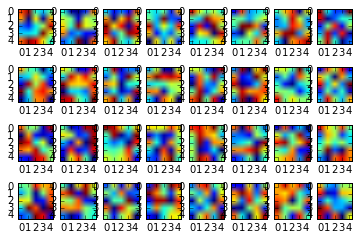

In [124]:
for index, weights in enumerate(model.layers[0].get_weights()[0]):
    plt.subplot(4, 8, index + 1)
    plt.imshow(weights.reshape((5, 5)))
plt.show()

¯\_(ツ)_/¯